In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [2]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Tensorflow
import tensorflow as tf

# Keras-tuner
import keras_tuner as kt

# Pickle
import pickle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Import data
df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIN                     34299 non-null  int64 
 1   NAME                    34299 non-null  object
 2   APPLICATION_TYPE        34299 non-null  object
 3   AFFILIATION             34299 non-null  object
 4   CLASSIFICATION          34299 non-null  object
 5   USE_CASE                34299 non-null  object
 6   ORGANIZATION            34299 non-null  object
 7   STATUS                  34299 non-null  int64 
 8   INCOME_AMT              34299 non-null  object
 9   SPECIAL_CONSIDERATIONS  34299 non-null  object
 10  ASK_AMT                 34299 non-null  int64 
 11  IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.1+ MB


In [5]:
# Drop the EIN and Name columns
cols = ["EIN", "NAME"]
df.drop(columns=cols, inplace=True)
df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [6]:
# Check the unique values per column
df.nunique()

,0
APPLICATION_TYPE,17
AFFILIATION,6
CLASSIFICATION,71
USE_CASE,5
ORGANIZATION,4
STATUS,2
INCOME_AMT,9
SPECIAL_CONSIDERATIONS,2
ASK_AMT,8747
IS_SUCCESSFUL,2


Given the value counts, Application Type and Classification look like they'll need to be binned.

In [7]:
# Value counts for Application Type
df.APPLICATION_TYPE.value_counts()

,count
APPLICATION_TYPE,
T3,27037
T4,1542
T6,1216
T5,1173
T19,1065
T8,737
T7,725
T10,528
T9,156


In [8]:
# Set limit for "Other" bin
limit = 250
atc = df.APPLICATION_TYPE.value_counts()
app_to_replace = atc.loc[atc < limit].index.tolist()

# Replace values in DataFrame
for app in app_to_replace:
  df["APPLICATION_TYPE"] = df.APPLICATION_TYPE.replace(app, "Other")

# Verify "Other" bin
df.APPLICATION_TYPE.value_counts()

,count
APPLICATION_TYPE,
T3,27037
T4,1542
T6,1216
T5,1173
T19,1065
T8,737
T7,725
T10,528
Other,276


In [9]:
# Value counts for Classification
df.CLASSIFICATION.value_counts()

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
...,...
C4120,1
C8210,1
C2561,1


In [10]:
# Set limit for "Other" bin
limit = 300
cvc = df.CLASSIFICATION.value_counts()
cat_to_replace = cvc.loc[cvc < limit].index.tolist()

# Replace values in DataFrame
for cat in cat_to_replace:
  df["CLASSIFICATION"] = df.CLASSIFICATION.replace(cat, "Other")

# Verify "Other" bin
df.CLASSIFICATION.value_counts()

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
Other,1484
C7000,777


In [11]:
display(df.columns)
df.info()

Index(['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'STATUS', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS',
       'ASK_AMT', 'IS_SUCCESSFUL'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        34299 non-null  object
 1   AFFILIATION             34299 non-null  object
 2   CLASSIFICATION          34299 non-null  object
 3   USE_CASE                34299 non-null  object
 4   ORGANIZATION            34299 non-null  object
 5   STATUS                  34299 non-null  int64 
 6   INCOME_AMT              34299 non-null  object
 7   SPECIAL_CONSIDERATIONS  34299 non-null  object
 8   ASK_AMT                 34299 non-null  int64 
 9   IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.6+ MB


In [12]:
# One-hot encode categorical columns
cat_cols = ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS']

# Use pd.get_dummies
df = pd.get_dummies(df, columns=cat_cols, dtype=int)
df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C7000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1,108590,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,5000,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,1,6692,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
4,1,142590,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [13]:
# Train-Test-Split
# Get the Data
X = df.drop(columns=["IS_SUCCESSFUL"])
y = df.IS_SUCCESSFUL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

print(X_train.shape, X_test.shape)

(25724, 44) (8575, 44)


In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Note: Due to program requirements, I am scaling the entire dataset.

In the future would try to either scale the "ASK_AMT" column using either np.ravel() or other methods detailed [here](https://www.geeksforgeeks.org/normalize-a-column-in-pandas/)

### Network 1
---
Base model done in class\
No tweeks made to the model\
Baseline test

In [15]:
# Create the Keras Sequential model
nn_model1 = tf.keras.models.Sequential()

# Add our first Dense layer (hidden layer), including the input layer
# input_dim only in 1st layer
nn_model1.add(tf.keras.layers.Dense(units=7, activation="relu", input_dim=len(X.columns)))

# Add in a second layer
# Use fewer layers than the 1st one
nn_model1.add(tf.keras.layers.Dense(units=5, activation="relu"))

# Add in a third layer
nn_model1.add(tf.keras.layers.Dense(units=3, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model1.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 7)                   │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 377 (1.47 KB)

 Trainable params: 377 (1.47 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Add in early stop
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the Sequential model together and customize metrics
nn_model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model1 = nn_model1.fit(X_train_scaled, y_train, epochs=500, callbacks=[stop_early])

Epoch 1/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5700 - loss: 0.6720
Epoch 2/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7226 - loss: 0.5746
Epoch 3/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7276 - loss: 0.5620
Epoch 4/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7230 - loss: 0.5641
Epoch 5/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7244 - loss: 0.5593
Epoch 6/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7248 - loss: 0.5597
Epoch 7/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7282 - loss: 0.5569
Epoch 8/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7275 - loss: 0.5536
Epoch 9/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7327 - loss: 0.5513
Epoch 10/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7300 - loss: 0.5537
Epoch 11/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7325 - loss: 0.5496
Epoch 12/500
804/804 ━━━━━━━━━━━━━━━━━━━━

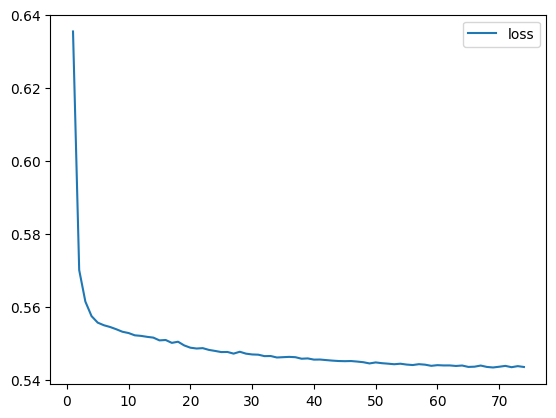

In [17]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model1.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

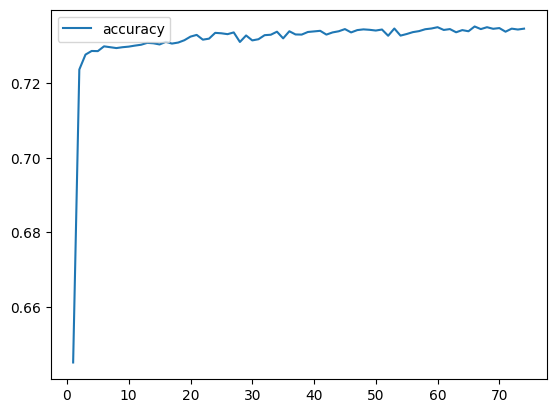

In [18]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [19]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model1.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - 3ms/step - accuracy: 0.4676 - loss: 0.6978
Loss: 0.697834849357605, Accuracy: 0.4676384925842285


### Network 2
---
Adding 2 more neurons to each layer to try and increase accuracy in the model

In [20]:
# Create the Keras Sequential model
nn_model2 = tf.keras.models.Sequential()

# Add our first Dense layer (hidden layer), including the input layer
# input_dim only in 1st layer
nn_model2.add(tf.keras.layers.Dense(units=9, activation="relu", input_dim=len(X.columns)))

# Add in a second layer
# Use fewer layers than the 1st one
nn_model2.add(tf.keras.layers.Dense(units=7, activation="relu"))

# Add in a third layer
nn_model2.add(tf.keras.layers.Dense(units=5, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 9)                   │             405 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Add in early stop
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the Sequential model together and customize metrics
nn_model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model2 = nn_model2.fit(X_train_scaled, y_train, epochs=500, callbacks=[stop_early])

Epoch 1/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5940 - loss: 0.6612
Epoch 2/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7262 - loss: 0.5654
Epoch 3/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7250 - loss: 0.5600
Epoch 4/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7291 - loss: 0.5527
Epoch 5/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7299 - loss: 0.5497
Epoch 6/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7291 - loss: 0.5506
Epoch 7/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7299 - loss: 0.5517
Epoch 8/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7297 - loss: 0.5501
Epoch 9/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7305 - loss: 0.5493
Epoch 10/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7325 - loss: 0.5465
Epoch 11/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7307 - loss: 0.5485
Epoch 12/500
804/804 ━━━━━━━━━━━━━━━━━━━━

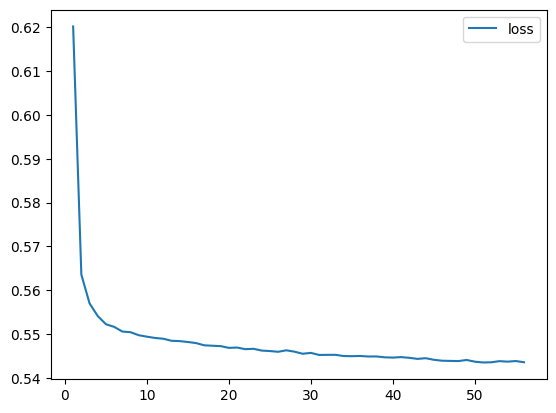

In [22]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model2.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

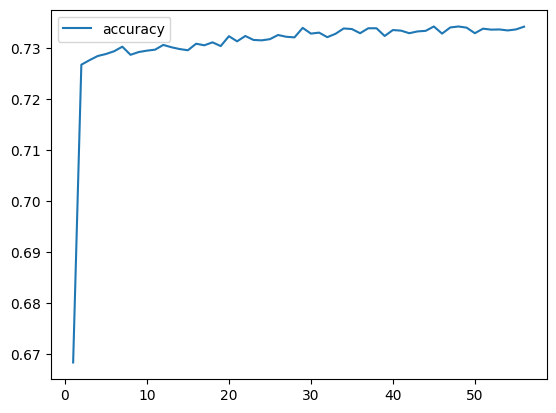

In [23]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model2.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - 3ms/step - accuracy: 0.5324 - loss: 23593.6113
Loss: 23593.611328125, Accuracy: 0.5323615074157715


Summary: Network 2 increased accuracy over Network 1, but the Loss was much more significant

### Network 3
---
Adding an extra layer to the model to see if that improves performance

In [25]:
# Create the Keras Sequential model
nn_model3 = tf.keras.models.Sequential()

# Add our first Dense layer (hidden layer), including the input layer
# input_dim only in 1st layer
nn_model3.add(tf.keras.layers.Dense(units=9, activation="relu", input_dim=len(X.columns)))

# Add in a second layer
# Use fewer layers than the 1st one
nn_model3.add(tf.keras.layers.Dense(units=7, activation="relu"))

# Add in a third layer
nn_model3.add(tf.keras.layers.Dense(units=5, activation="relu"))

# Add in a fourth layer
nn_model3.add(tf.keras.layers.Dense(units=3, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 9)                   │             405 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537 (2.10 KB)

 Trainable params: 537 (2.10 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Add in early stop
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the Sequential model together and customize metrics
nn_model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model3 = nn_model3.fit(X_train_scaled, y_train, epochs=500, callbacks=[stop_early])

Epoch 1/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6217 - loss: 0.6658
Epoch 2/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7188 - loss: 0.5700
Epoch 3/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7243 - loss: 0.5630
Epoch 4/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7265 - loss: 0.5555
Epoch 5/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7286 - loss: 0.5536
Epoch 6/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7274 - loss: 0.5510
Epoch 7/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7265 - loss: 0.5544
Epoch 8/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7283 - loss: 0.5493
Epoch 9/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7310 - loss: 0.5506
Epoch 10/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7310 - loss: 0.5476
Epoch 11/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7331 - loss: 0.5483
Epoch 12/500
804/804 ━━━━━━━━━━━━━━━━━━━━

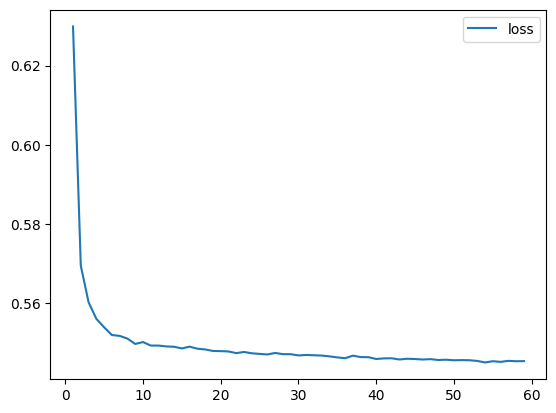

In [28]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model3.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

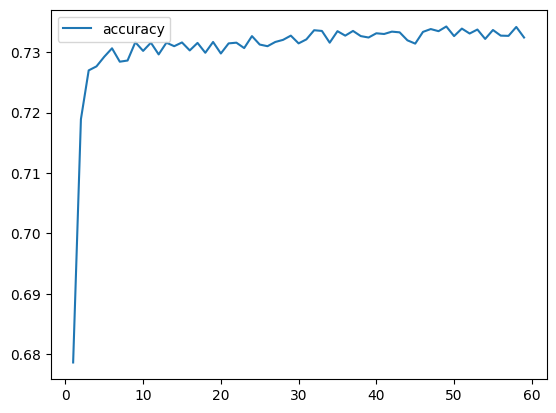

In [29]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [30]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model3.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - 2ms/step - accuracy: 0.4676 - loss: 88964.0156
Loss: 88964.015625, Accuracy: 0.4676384925842285


Summary: Network 3 is so far the worst perfomring of all 3 models in terms of loss and has roughly the same accuracy of Network 1

### Network 4
---
Increasing the number of neurons per each layer by 6

In [31]:
# Create the Keras Sequential model
nn_model4 = tf.keras.models.Sequential()

# Add our first Dense layer (hidden layer), including the input layer
# input_dim only in 1st layer
nn_model4.add(tf.keras.layers.Dense(units=15, activation="relu", input_dim=len(X.columns)))

# Add in a second layer
# Use fewer layers than the 1st one
nn_model4.add(tf.keras.layers.Dense(units=13, activation="relu"))

# Add in a third layer
nn_model4.add(tf.keras.layers.Dense(units=11, activation="relu"))

# Add in a fourth layer
nn_model4.add(tf.keras.layers.Dense(units=9, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 15)                  │             675 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 13)                  │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 11)                  │             154 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 9)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,155 (4.51 KB)

 Trainable params: 1,155 (4.51 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Early Stop
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the Sequential model together and customize metrics
nn_model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model4 = nn_model4.fit(X_train_scaled, y_train, epochs=500, callbacks=[stop_early])

Epoch 1/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6605 - loss: 0.6289
Epoch 2/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7283 - loss: 0.5576
Epoch 3/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7347 - loss: 0.5497
Epoch 4/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7293 - loss: 0.5529
Epoch 5/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7311 - loss: 0.5498
Epoch 6/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7342 - loss: 0.5434
Epoch 7/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7337 - loss: 0.5458
Epoch 8/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7305 - loss: 0.5459
Epoch 9/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7311 - loss: 0.5458
Epoch 10/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7349 - loss: 0.5455
Epoch 11/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7340 - loss: 0.5437
Epoch 12/500
804/804 ━━━━━━━━━━━━━━━━━━━━

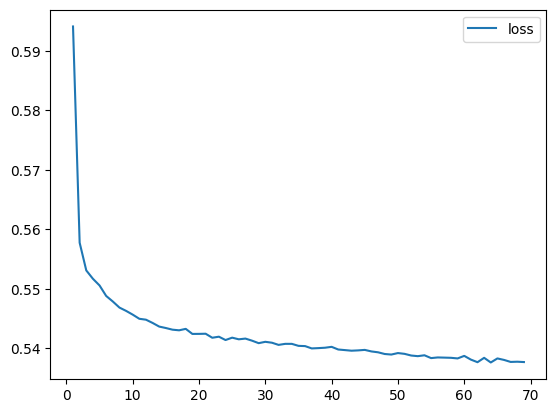

In [33]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model4.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

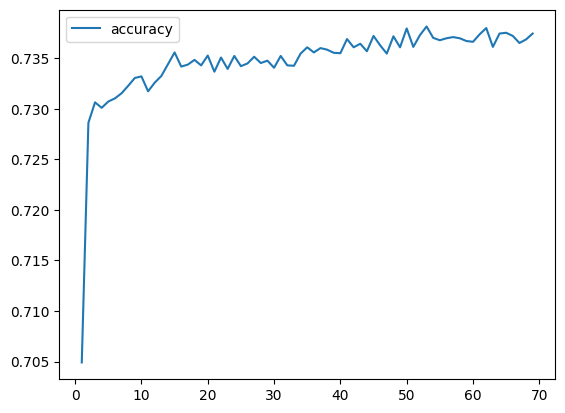

In [34]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [35]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model4.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - 3ms/step - accuracy: 0.4676 - loss: 4217.5391
Loss: 4217.5390625, Accuracy: 0.4676384925842285


Summary: Network 4 performed about the same as Networks 1 and 3 in regards to Accuracy. However, Network 1 had much better loss.

#### Network 5:
---
Removing the 4th layer, but keeping the increased neurons from Network 4

In [37]:
# Create the Keras Sequential model
nn_model5 = tf.keras.models.Sequential()

# Add our first Dense layer (hidden layer), including the input layer
# input_dim only in 1st layer
nn_model5.add(tf.keras.layers.Dense(units=15, activation="relu", input_dim=len(X.columns)))

# Add in a second layer
# Use fewer layers than the 1st one
nn_model5.add(tf.keras.layers.Dense(units=13, activation="relu"))

# Add in a third layer
nn_model5.add(tf.keras.layers.Dense(units=11, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model5.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                     │ (None, 15)                  │             675 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 13)                  │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 11)                  │             154 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,049 (4.10 KB)

 Trainable params: 1,049 (4.10 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Early Stop
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the Sequential model together and customize metrics
nn_model5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model5 = nn_model5.fit(X_train_scaled, y_train, epochs=500, callbacks=[stop_early])

Epoch 1/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6629 - loss: 0.6304
Epoch 2/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7267 - loss: 0.5590
Epoch 3/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7306 - loss: 0.5520
Epoch 4/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7325 - loss: 0.5471
Epoch 5/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7320 - loss: 0.5467
Epoch 6/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7330 - loss: 0.5451
Epoch 7/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7244 - loss: 0.5529
Epoch 8/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7344 - loss: 0.5472
Epoch 9/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7340 - loss: 0.5444
Epoch 10/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7299 - loss: 0.5486
Epoch 11/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7327 - loss: 0.5433
Epoch 12/500
804/804 ━━━━━━━━━━━━━━━━━━━━

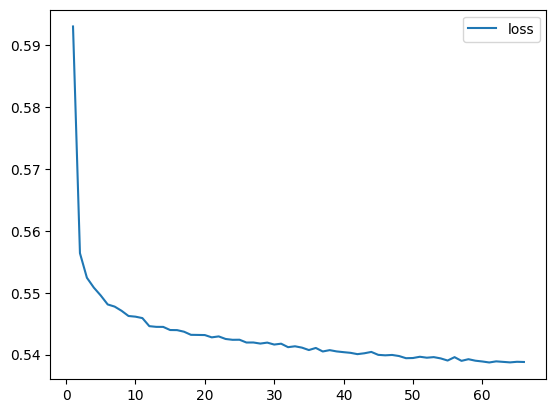

In [39]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model5.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

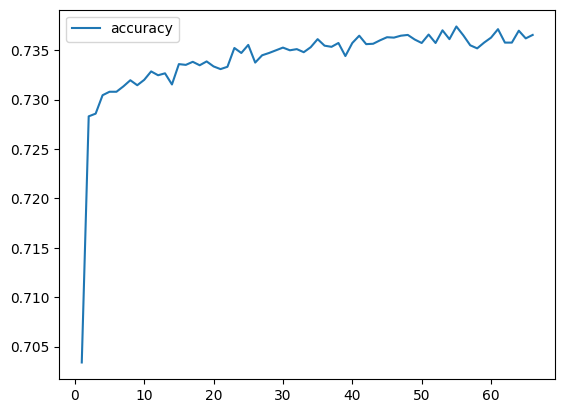

In [40]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [42]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model5.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - 2ms/step - accuracy: 0.5324 - loss: 12930.9834
Loss: 12930.9833984375, Accuracy: 0.5323615074157715


Summary: Looks to have similar accuracy to Network 2, but much better loss.\
\
Of the models optimized by me, it looks like Network 5 is the best. However, it still falls well short of the accuracy target of 75%

### Network 6:
---
Using Keras-Tuner to try to get a more optimized model

In [43]:
# Create a method that creates a new Sequential model with hyperparameter options
# Booth has some thoughts; cannot use it on sklearn
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=2), activation=activation, input_dim=len(X.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=2),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [44]:
# Add in early stop
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=50,
    hyperband_iterations=2)

# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test), callbacks=[stop_early])

Trial 180 Complete [00h 02m 05s]
val_accuracy: 0.7302623987197876

Best val_accuracy So Far: 0.7322449088096619
Total elapsed time: 01h 32m 20s


In [47]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 19,
 'num_layers': 2,
 'units_0': 29,
 'units_1': 19,
 'units_2': 19,
 'units_3': 23,
 'units_4': 23,
 'units_5': 3,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0055'}

In [46]:
# Evaluate best model against full test data
kn_nn_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = kn_nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - 2ms/step - accuracy: 0.7322 - loss: 0.5544
Loss: 0.5544357299804688, Accuracy: 0.7322449088096619


Summary: The best model by far looks to be the Keras-tuner model. However, even using Keras-Tuner, the model falls short of the 75% target. This could be because more neurons are needed. However, it is more likely that the problems with the models include:
- Scaling the encoded data
- Need to drop more columns (there are a number of features with minimal predictive power of minority classes)
- Additional features could have been binned where minority classes could have been moved into "Other" categories

### Export the model

In [48]:
# Save the best model created without the keras-tuner (Network 2)
nn_model5.save("optimal_model.h5")

# Save the best keras-tuner model
kn_nn_model.save("best_keras_tuner_model.h5")